In [213]:
import xarray as xr
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import cmocean.cm as ocm

proj_dir = os.path.join(os.pardir,os.pardir)
data_dir = os.path.join(proj_dir,'data')
src_dir = os.path.join(proj_dir,'src')

sys.path.append(src_dir)
%load_ext autoreload
%autoreload 1

from tools.roms_ds_tools import make_4D_depth
%aimport tools.roms_ds_tools

from tools.log_progress import log_progress
from tools.rotate_vector_roms import  rotate_vector_roms

grd_path = os.path.join(data_dir,'preprocessing','processed','waom10_grd.nc')
avg_path = os.path.join(data_dir,'analysis','raw','waom10','ocean_avg_0006.nc')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
avg = xr.open_dataset(avg_path)
grd = xr.open_dataset(grd_path)

In [3]:
avg = make_4D_depth(avg)

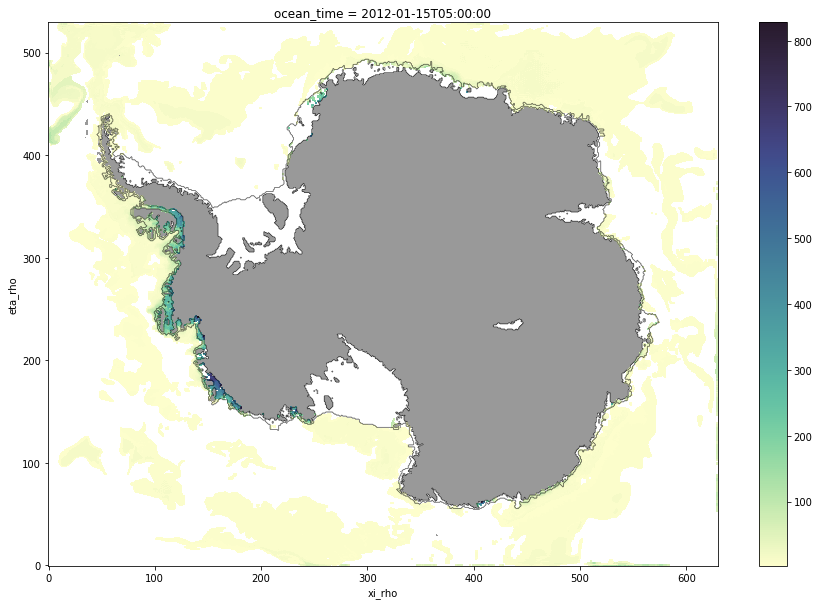

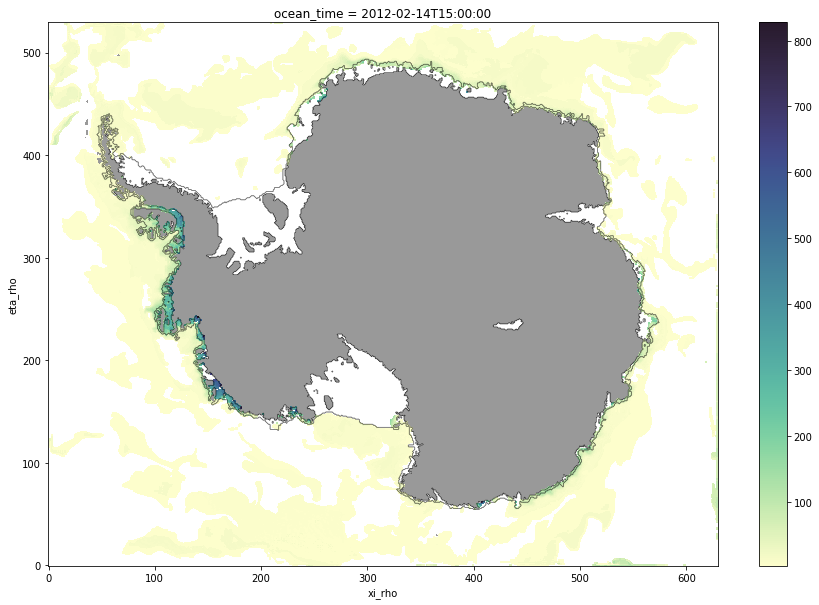

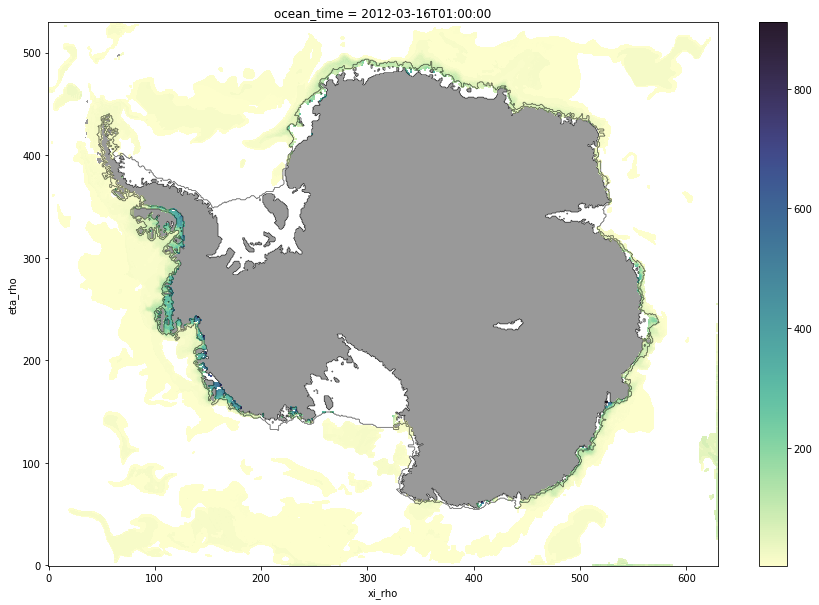

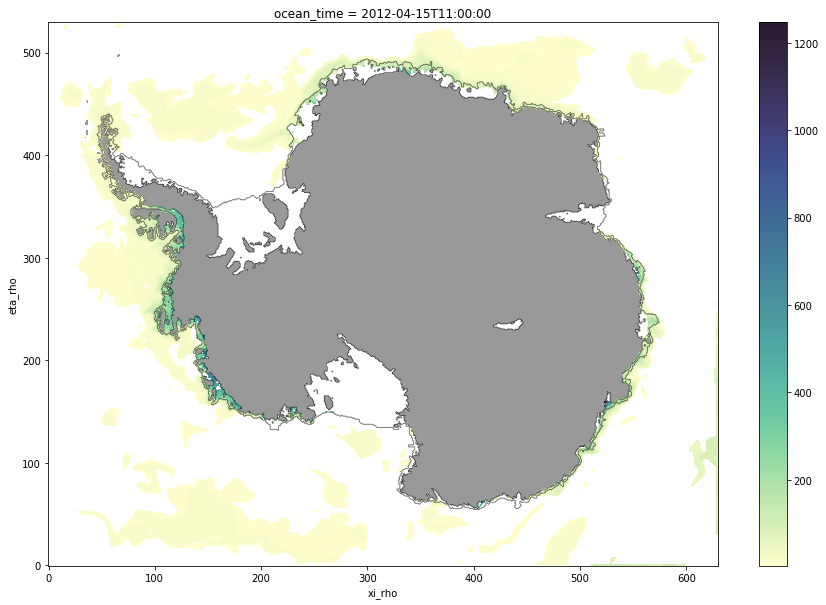

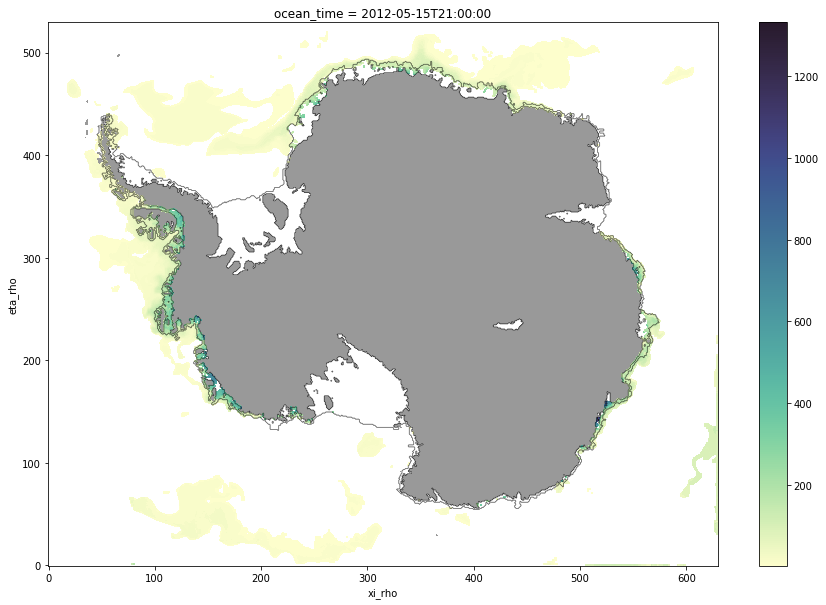

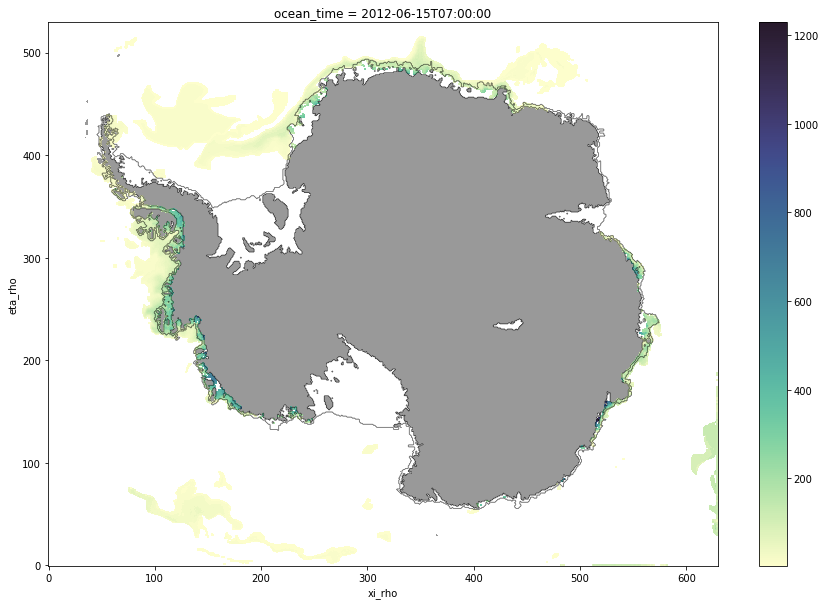

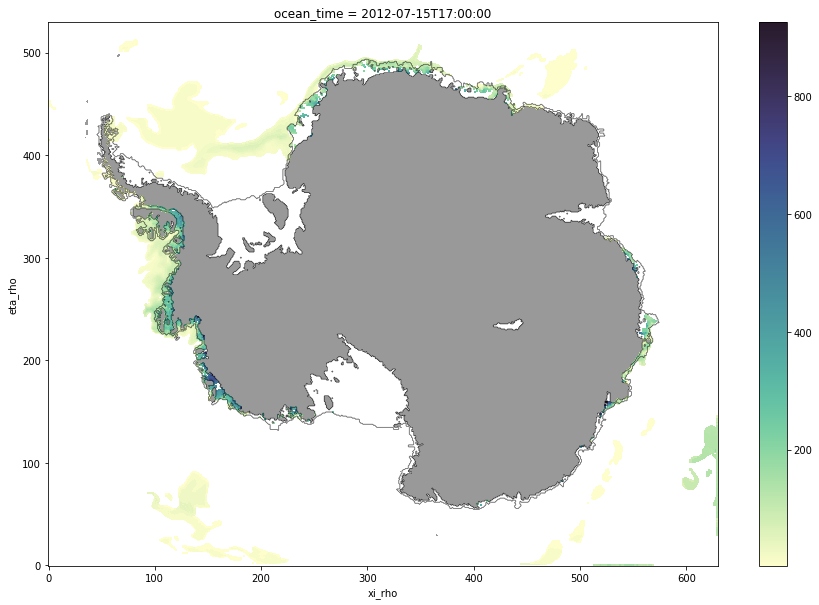

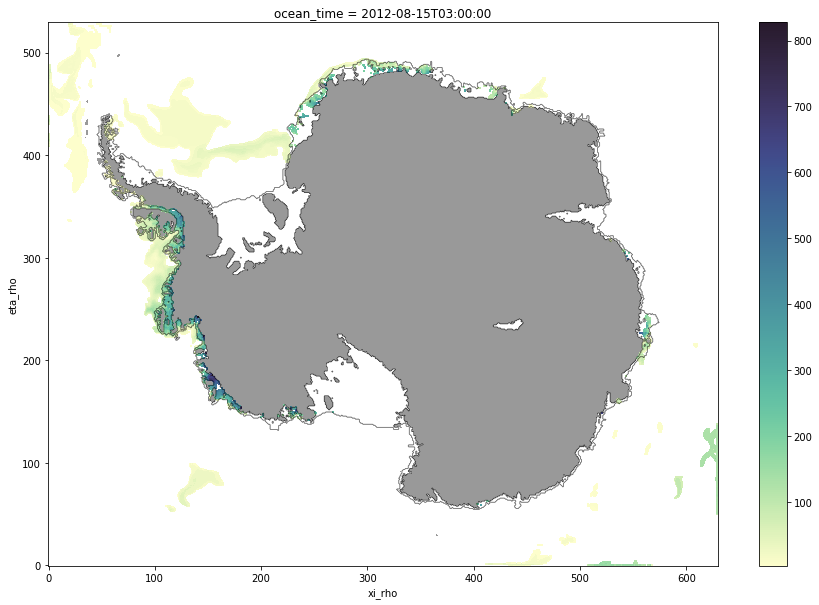

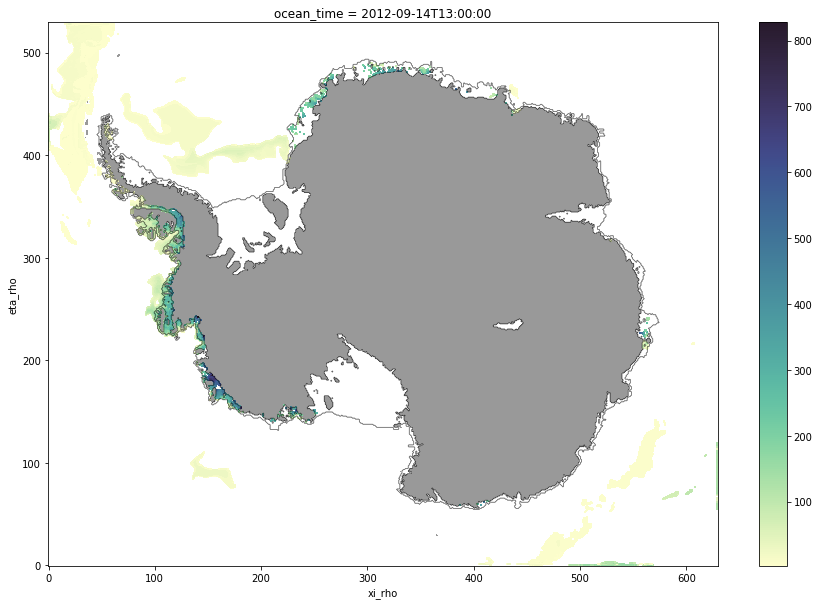

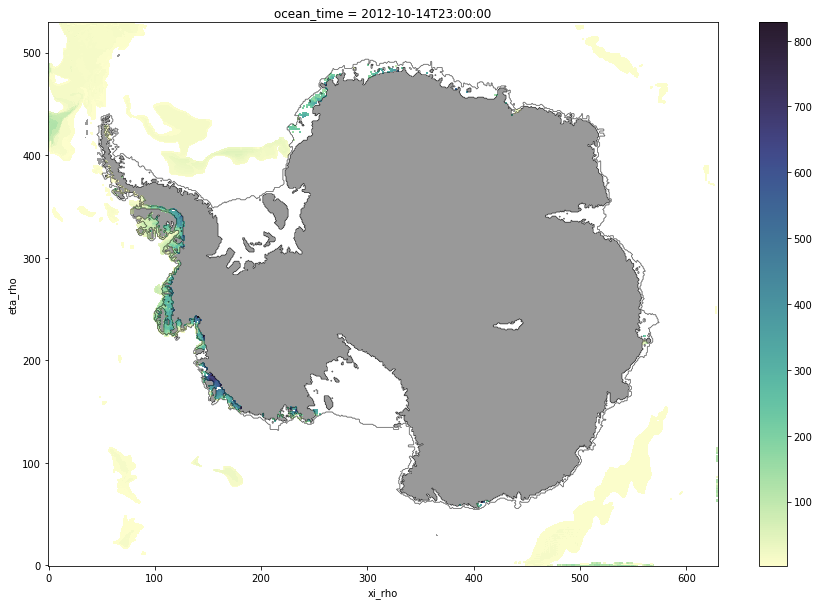

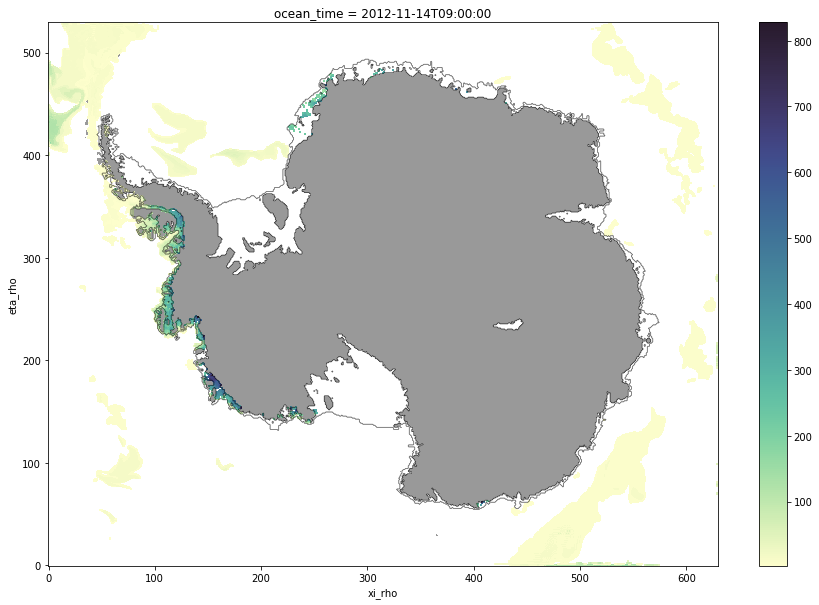

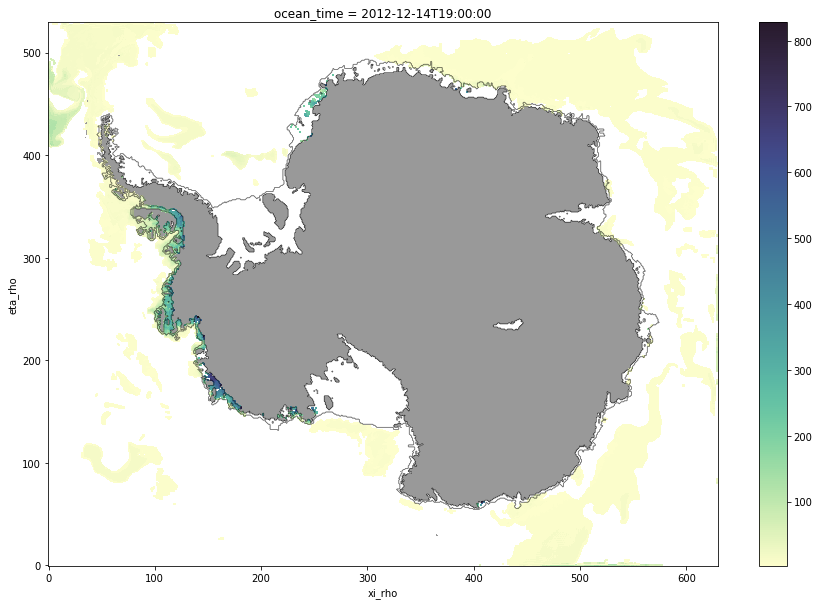

In [136]:
for time in np.arange(avg.ocean_time.size):
    plt.close()
    fig,ax = plt.subplots(figsize=(15,10))
    mask_AASW = (avg.isel(ocean_time=time).salt<=34) & (avg.isel(ocean_time=time).temp>-1.9)
    ax.contourf(grd.mask_rho.where(grd.mask_rho==0).values,colors=(('0.6','0.6','0.6')))
    (avg.isel(ocean_time=time).depth.where(mask_AASW).min('s_rho')*-1).plot(ax=ax,cmap=ocm.deep)
    ax.contour((grd.mask_rho ==1) & (grd.zice<0.0), colors=('black'),linewidths=0.1)
    plt.show()

In [230]:
sustr_path = os.path.join(data_dir,'preprocessing','processed','waom10_sustr.nc')
svstr_path = os.path.join(data_dir,'preprocessing','processed','waom10_svstr.nc')

gustr = xr.open_dataset(sustr_path).sustr
gvstr = xr.open_dataset(svstr_path).svstr

llustr,llvstr = rotate_vector_roms(gustr.mean('sms_time').values,gvstr.mean('sms_time').values,grd.angle)

ustr = grd.mask_rho.copy()
ustr.values = llustr
ustr.attrs=gustr.attrs

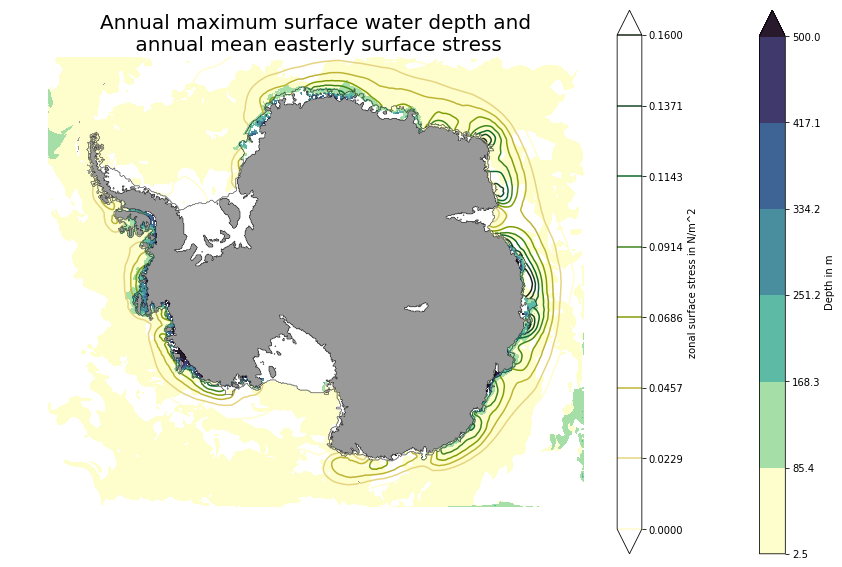

In [265]:
%matplotlib inline
plt.close()
fig,ax = plt.subplots(figsize=(15,10))
mask_AASW = (avg.salt<=34) & (avg.temp>-1.9)
ax.contourf(grd.mask_rho.where(grd.mask_rho==0).values,colors=(('0.6','0.6','0.6')))
depth_plt = (avg.depth.where(mask_AASW).min(['s_rho','ocean_time'])*-1).plot.contourf(ax=ax,add_colorbar=False,cmap=ocm.deep,vmax=500)
fig.colorbar(depth_plt,ax=ax,extend='both',label='Depth in m')
ustr_plt = (ustr.where((grd.mask_rho == 1) & (grd.zice == 0))*-1).plot.contour(ax=ax,levels=np.linspace(0,0.16,8),cmap=ocm.speed)
fig.colorbar(ustr_plt,ax=ax,extend='both',label='zonal surface stress in N/m^2')
ax.contour((grd.mask_rho ==1) & (grd.zice<0.0), colors=('black'),linewidths=0.1)
ax.set_aspect('equal')
plt.title('Annual maximum surface water depth and\n annual mean easterly surface stress', fontsize=20)
ax.axis('off')
out_path = os.path.join(proj_dir,'reports','figures','max_AASW_depth.png')
plt.savefig(out_path,format='png',dpi=200)
plt.show()

In [102]:
def make_mask_coast(grd,nb_cells):
    
    mask_open_ocean = (grd.mask_rho.values==1) & (grd.zice.values==0)
    
    mask_coast = np.zeros_like(mask_open_ocean)
    
    for j in log_progress(grd.eta_rho.values):
        for i in grd. xi_rho.values:
            if mask_open_ocean[j,i] == 1:
                j_min = max(j-nb_cells,0)
                j_max = min(j+nb_cells, np.size(grd.mask_rho,0))
                i_min = max(i-nb_cells,0)
                i_max = min(i+nb_cells+1, np.size(grd.mask_rho,1))

                if np.any(mask_open_ocean[j_min:j_max,i_min:i_max] == 0):
                        mask_coast[j,i] = 1
                        
    grd['mask_coast'] = (('eta_rho','xi_rho'),mask_coast)
    
    return grd

grd = make_mask_coast(grd,2)

In [44]:
grd.to_netcdf(os.path.join(data_dir,'analysis','interim','grd10_mask_coast.nc'))

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


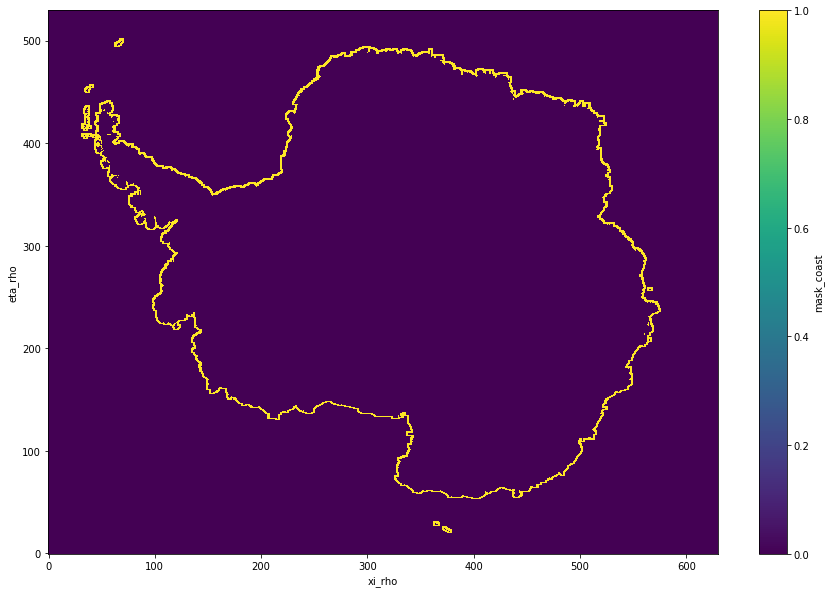

In [103]:
plt.close()
plt.subplots(figsize=(15,10))
grd.mask_coast.plot()
plt.show()

In [266]:
x_depth = avg.isel(ocean_time=0).depth.where(grd.mask_coast).mean(['eta_rho','xi_rho'])
salt = avg.salt.where(grd.mask_coast).mean(['eta_rho','xi_rho']).assign_coords(depth = x_depth.drop('ocean_time'))
temp = avg.temp.where(grd.mask_coast).mean(['eta_rho','xi_rho']).assign_coords(depth = x_depth.drop('ocean_time'))

In [317]:
s2a = 3600*24*365.25
rhoi = 916

mask = (grd.mask_rho==1) & (grd.zice<0.0)

dA = (1/(grd.pm*grd.pn)).where(mask)
A = dA.sum(['xi_rho','eta_rho'])
weights= dA/dA.sum()
ismr2bmb = dA*rhoi*(10**-12)

ismr = (avg.m*weights).sum(['xi_rho','eta_rho'])*s2a
bmb =  (avg.m*ismr2bmb).sum(['xi_rho','eta_rho'])*s2a

In [318]:
mask_AASW = ((avg.salt<=34) & (avg.temp>-1.9)).isel(s_rho=30)
dA = (1/(grd.pm*grd.pn)).where(mask_AASW)
weights=dA/dA.sum(['xi_rho','eta_rho'])
ismr2bmb = dA*rhoi*(10**-12)

ismr_AASW = (avg.m*weights).sum(['xi_rho','eta_rho']).drop('s_rho')*s2a
A_AASW = dA.sum(['xi_rho','eta_rho']).drop('s_rho')*10**-12
bmb_AASW =  (avg.m*ismr2bmb).sum(['xi_rho','eta_rho']).drop('s_rho')*s2a

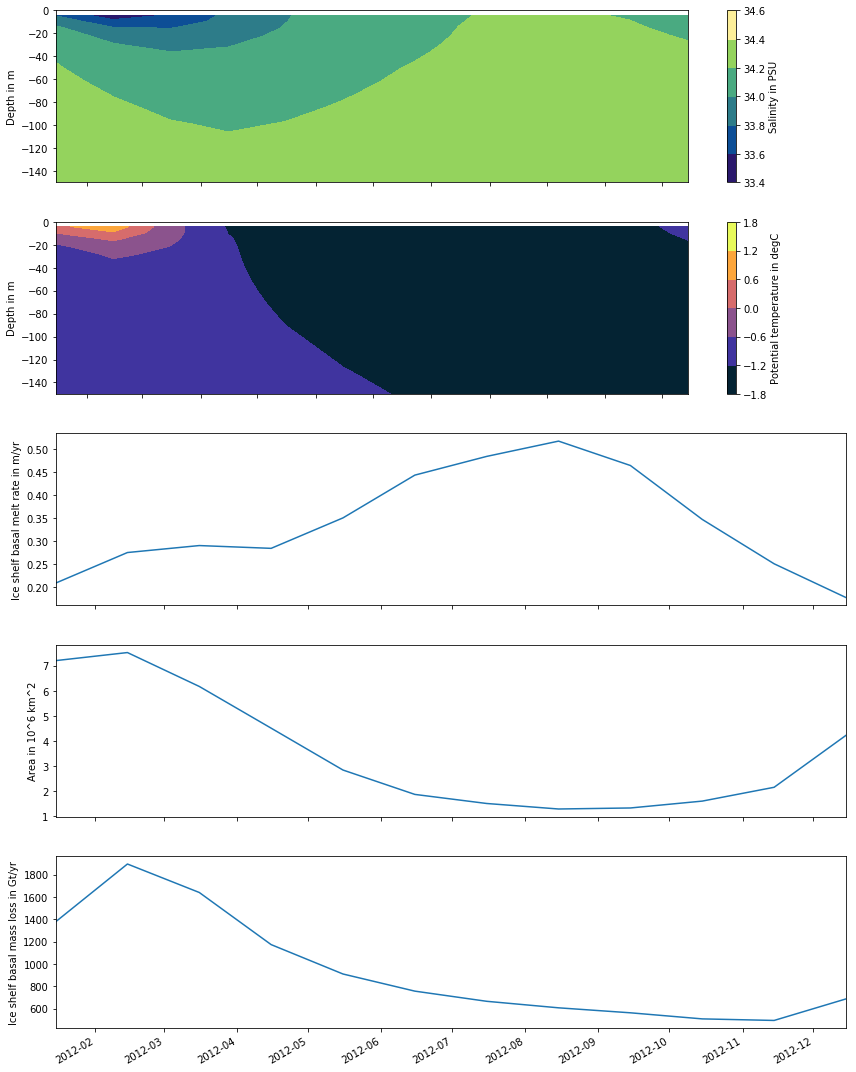

In [333]:
plt.close()
fig,axes = plt.subplots(nrows=5,figsize=(12,15),sharex=True)
salt_plt = salt.plot.contourf(x='ocean_time',y='depth',ax=axes[0],cmap=ocm.haline,add_colorbar=False)
fig.colorbar(salt_plt,ax=axes[0],extend='both',label='Salinity in PSU')
temp_plt = temp.plot.contourf(x='ocean_time',y='depth',ax=axes[1],cmap=ocm.thermal,add_colorbar=False)
fig.colorbar(temp_plt,ax=axes[1],extend='both',label='Potential temperature in degC')
for ax in axes[:2]:
    ax.set_ylim([-150,0])
    ax.set_ylabel('Depth in m')
ismr_AASW.plot(ax=axes[2])
axes[2].set_ylabel('Ice shelf basal melt rate in m/yr')
A_AASW.plot(ax=axes[3])
axes[3].set_ylabel('Area in 10^6 km^2')
bmb_AASW.plot(ax=axes[4])
axes[4].set_ylabel('Ice shelf basal mass loss in Gt/yr')
for ax in axes.flatten():
    ax.set_xlabel('')
plt.tight_layout()
out_path = os.path.join(proj_dir,'reports','figures','AASW_bmb.png')
plt.savefig(out_path,format='png',dpi=200)
plt.show()

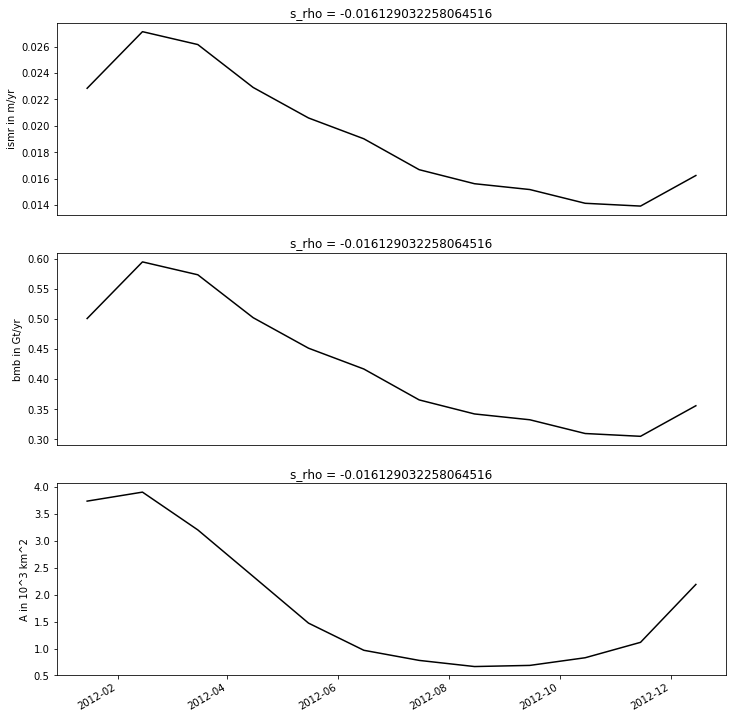

In [210]:
plt.close()
fig,axes = plt.subplots(3,figsize=(12,12))
ax1,ax2,ax3 = axes.flatten()
#ismr.plot(ax=ax1,color='k')
(ismr_AASW/ismr).plot(ax=ax1,color='k')
(bmb_AASW/bmb).plot(ax=ax2,color='k')
(A_AASW/A).plot(ax=ax3,color='k')
ax1.set_ylabel('ismr in m/yr')
ax2.set_ylabel('bmb in Gt/yr')
ax3.set_ylabel('A in 10^3 km^2')
for ax in [ax1,ax2]:
    ax.set_xticks([])
    ax.set_xlabel('')
ax3.set_xlabel('')
#plt.savefig(os.path.join(fig_dir,'depth_bins.png'),transparent=True,dpi=300)
plt.show()

In [159]:
A = 1/(grd.pm*grd.pn)/1000000

A_AASW = A.where(grd.zice<0.0).where(mask_AASW.isel(s_rho=30)).sum(['eta_rho','xi_rho'])/A.where(grd.zice<0.0).sum()

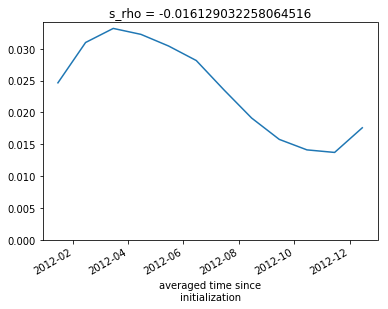

In [165]:
plt.close()
fig,ax = plt.subplots()
A_AASW.plot()
ax.set_ylim(0)
plt.show()

In [339]:
d = {'a':[0,2,4],'b':[1,5,7]}
max(d[max(d)])

7